# Implement V subtraction method

### Apr 6, 2021

## Code

In [1]:
import sys
import csv
# sys.path.insert(0,"/users/PCON0003/cond0068/.local/lib/python3.7/")
sys.path.append("/users/PAS0654/osu8354/ARA_cvmfs/root_build/lib/") # go to parent dir
sys.path.append("/users/PCON0003/cond0068/.local/lib/python3.7/site-packages/")
# sys.path.append("/users/PCON0003/cond0068/pyrex_sims/fromBen/thesis_work/pyrex-custom/analysis/custom/analysis/")
# import ROOT
import math
import numpy as np
# from ROOT import TH1D,TF1, gRandom, gPad, gStyle
import matplotlib as mpl
import matplotlib.pyplot as plt
# from ROOT import TChain, TSelector, TTree
import os
import matplotlib.colors as mcolors
import scipy
from matplotlib.colors import LogNorm
import pandas as pd
import pyrex
import seaborn as sns
%matplotlib inline
sys.path.insert(1, "/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/ARA_analysis/CenA_sourceSearch/Stokes")
# import deDisperse_util as util
# from pyrex.internal_functions import normalize
my_path_plots = os.path.abspath("./plots/")
# import pyrex.custom.ara as ara


In [2]:
# mpl.use('agg') 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.unicode'] = True
mpl.rcParams['mathtext.rm'] = 'Times New Roman'
mpl.rcParams['mathtext.it'] = 'Times New Roman:italic'
mpl.rcParams['mathtext.bf'] = 'Times New Roman:bold'

mpl.rc('font', family='serif', size=12)
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['ytick.major.size'] = 5

mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 18
# mpl.rc('font', size=16)
mpl.rc('axes', titlesize=20)

current_palette = sns.color_palette('colorblind', 10)
import warnings
warnings.filterwarnings("ignore")
import time

## Aux. functions

In [3]:
def rotation_matrix_from_vectors(vec1, vec2):
    """ Find the rotation matrix that aligns vec1 to vec2
    :param vec1: A 3d "source" vector
    :param vec2: A 3d "destination" vector
    :return mat: A transform matrix (3x3) which when applied to vec1, aligns it with vec2.
    """
    a, b = (vec1 / np.linalg.norm(vec1)).reshape(3), (vec2 / np.linalg.norm(vec2)).reshape(3)
    v = np.cross(a, b)
    c = np.dot(a, b)
    s = np.linalg.norm(v)
    kmat = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
    rotation_matrix = np.eye(3) + kmat + kmat.dot(kmat) * ((1 - c) / (s ** 2))
    return rotation_matrix

def rotatePolVector(launchVecSrc, recVec, PolVecAntenna):
    recVec = -recVec #receiving vector needs to be reflected, otherwise rotation matrix will be off by pi
    newPol = np.dot(PolVecAntenna,rotation_matrix_from_vectors(launchVecSrc,recVec))
    return newPol

def Rx(theta):
    return np.matrix([[ 1, 0           , 0           ],
                   [ 0, np.cos(theta),-np.sin(theta)],
                   [ 0, np.sin(theta), np.cos(theta)]])

## Expected polarization 

In [4]:
def estimatePolRayTracer(depth):
    #Take depth of pulser and calculate polarization rotation based on raytracer results.
    rt = pyrex.RayTracer(from_point=(0, 0, -depth), to_point=(2400, 0, -179.93)) #Use the depth of the transmitter as the z-
    #coordinate. A2 is at a horizontal distance of 2400 m from the pulser, and at a depth of 179.93 m
    path = rt.solutions[0] #We only care about direct solutions
    rotMat = rotation_matrix_from_vectors(path.received_direction,path.emitted_direction)
    initPulserPol = np.array([0,0,1])
#     initPulserPol = np.array([np.sqrt(0.25/2),np.sqrt(0.25/2),np.sqrt(0.75)])
    rotAngle = np.pi/2-np.arccos(path.emitted_direction[2])
#     pulserPol = np.array(np.matmul(initPulserPol,Rx(rotAngle)))[0]
    rotatedPol = np.dot(initPulserPol,rotMat)
    newOmegaPol = np.degrees(np.arccos(rotatedPol[2]))
    polFinal = newOmegaPol-np.degrees(rotAngle)
    return polFinal, np.degrees(rt.solutions[0].theta0), 180-np.degrees(np.arccos(path.received_direction[2]))

# Soft triggers distribution

In [23]:
wf = pd.read_pickle("/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/ARA_analysis/ARA_Reconstruction/DPulseWforms_run012559_allDepths.pkl")
softWf = pd.read_pickle("/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/ARA_analysis/ARA_Reconstruction/SoftTrigWforms_run012559.pkl")
wf = wf.loc[wf.theta_reco>=90]

### Add interpolated depth to df

In [24]:
depth_1224 = pd.read_csv("./plots/SpiceCorePolReco/A2_1224Depth.txt")
time = pd.to_datetime(depth_1224.NZ_Time)
# time = time.reindex(time)
# time = time.tz_localize('NZ').tz_convert("UTC")
time.head()
newTime = time.apply(lambda dt: dt.replace(day=24, month = 12, year = 2018))
# newTime#Still in NZ local time. Need to translate to UTC
df = pd.DataFrame(1, index=newTime, columns=['X'])
import pytz
nz = pytz.timezone('NZ')
utc = pytz.timezone('UTC')
df.index = df.index.tz_localize(nz).tz_convert(utc)
unixTimeDepth = (df.index - pd.Timestamp("1970-01-01").tz_localize(utc)) // pd.Timedelta('1s')#This is unix time 

In [25]:
f = scipy.interpolate.interp1d(unixTimeDepth, depth_1224.depth,bounds_error=False, fill_value=0.)
wf = wf.loc[(wf.unixTime>min(wf.unixTime)) & (wf.unixTime<2.15*1E4+1.5456*1E9)]
softWf = softWf.loc[(softWf.unixTime>min(wf.unixTime)) & (softWf.unixTime<2.15*1E4+1.5456*1E9)]

interp_depth = f(wf.unixTime)
interp_depthSoft = f(softWf.unixTime)

wf["interp_depth"] = interp_depth
softWf["interp_depth"] = interp_depthSoft

In [27]:
depth_1229

,NZ_Time,depth
0,13:15,0
1,13:21,80
2,13:22,168
3,13:35,200
4,13:47,200
...,...,...
56,19:31,200
57,19:35,150
58,19:41,100
59,19:45,50


In [16]:
def calculatePower(t, v):
    dT = t[1]-t[0]
    power = np.sum(v**2)*dT
    return power

In [17]:
wf.columns

Index(['evNum', 'ch0Wf', 'ch1Wf', 'ch2Wf', 'ch3Wf', 'ch4Wf', 'ch5Wf', 'ch6Wf',
       'ch7Wf', 'ch8Wf', 'ch9Wf', 'ch10Wf', 'ch11Wf', 'ch12Wf', 'ch13Wf',
       'ch14Wf', 'ch15Wf', 'times', 'theta_reco', 'phi_reco', 'unixTime',
       'interp_depth'],
      dtype='object')

In [22]:
# wf = wf.drop(columns=['evNum','theta_reco', 'phi_reco', 'unixTime'])
wf

,ch0Wf,ch1Wf,ch2Wf,ch3Wf,ch4Wf,ch5Wf,ch6Wf,ch7Wf,ch8Wf,ch9Wf,ch10Wf,ch11Wf,ch12Wf,ch13Wf,ch14Wf,ch15Wf,times,interp_depth
1,"[23.212790984349784, 46.01801462120953, 13.763...","[-37.94826970904755, 40.671615208374064, 97.81...","[-148.26684025441895, -153.23772005810352, -25...","[-69.50610317184528, -51.55386746840601, 36.01...","[-32.56591089761726, 94.57179902768482, 115.12...","[70.79536431601043, 50.960373158861444, -33.09...","[127.86287139711183, 95.43282592078818, 33.873...","[0.7390379719936186, -85.89528553491475, -139....","[-47.55598335846651, -291.6574967572872, -248....","[-35.18745181166764, -48.34633860896134, -1.92...","[129.71740254750955, -62.61188991643582, -186....","[35.20774757617964, -59.72203336149784, -80.28...","[-99.99729733713824, -94.41274687237281, 87.82...","[-117.78239269976511, -83.82470735680145, -11....","[-58.890725450824725, -224.30815167900917, -24...","[-113.80983804280297, -190.95834101889233, -15...","[56.46902313679705, 56.96902313679705, 57.4690...",0.0
2,"[35.597791598482814, -0.880975030511886, -37.6...","[-104.09124616221332, -100.25765289509698, -40...","[240.3431957907339, 37.175691971622676, -166.1...","[87.98195252777967, 26.639143289689223, -43.15...","[-110.40133413815639, 5.506085174853232, 151.1...","[-102.37151691321489, -45.50257093558912, 61.1...","[40.70514827967156, 25.753290844246674, 18.883...","[156.14450421089754, 150.6633784962117, 35.203...","[-47.15868960886527, -66.40214171569785, -74.7...","[-94.86845453814296, -29.85719118993642, 74.49...","[121.36651236432976, 128.71680687678875, 18.86...","[39.55008702245418, -16.446925601630024, -117....","[59.66848014070435, -133.75308426993942, -188....","[67.58573267296678, 45.11725159775674, -10.629...","[-303.42700496826, -258.54146972427327, -65.69...","[-3.42433352350948, 91.16725231843316, 77.2556...","[57.96902313679705, 58.46902313679705, 58.9690...",0.0
3,"[-2.5891271120936983, -70.3482472822312, -84.5...","[-96.23553539383342, -100.8381469461719, -40.7...","[312.8134549239279, 208.71379436556765, -103.8...","[-57.94668122552355, -43.07146091062694, 6.133...","[-38.72978785692989, -53.58747649952095, -18.1...","[18.974650670091783, -10.370346396554073, -34....","[-69.18658056945424, 227.7644946011229, 320.49...","[-93.53572242286651, -31.756660346031317, 22.1...","[-17.07634790648626, -54.778367730927954, -120...","[44.699982186494616, -3.8317848273749666, -51....","[74.71840387417772, 190.3282613697085, 131.193...","[168.51611483885145, 229.23494394776446, 134.8...","[64.69843195344856, -67.32532561776407, -140.0...","[-39.53203608953014, 25.575712724940086, 103.3...","[38.1116945665992, 59.37398264461015, 20.72798...","[286.44135304500657, 125.02199844345031, -179....","[72.46902313679705, 72.96902313679705, 73.4690...",0.0
4,"[28.315898810976556, -26.988965226277124, -52....","[88.89755148794536, 110.03561987855505, 38.559...","[8.357096394389401, 37.282808775167446, 2.7432...","[-85.2032795129965, -69.73894372933302, -29.28...","[-98.8529277050182, 67.0386238786546, 133.7605...","[12.203913847306586, -67.53533904713527, -93.3...","[153.90078874134645, 11.063555625101374, -123....","[12.53829771428967, -36.36332916051902, -16.90...","[77.5133218691099, 62.94109528830387, -42.8851...","[26.1404655501748, 20.633972154423233, -21.930...","[42.23075738181691, 277.4699086105152, 342.655...","[125.13675145032674, -119.28718661313134, -238...","[-116.63872360997732, -44.03127753669941, 76.7...","[21.29914955051858, 23.98284115593369, -62.768...","[-213.52186000561906, -268.04716183866833, -19...","[-9.400120190379205, 146.17124220126942, 232.3...","[70.39507781669586, 70.89507781669586, 71.3950...",0.0
5,"[-15.792517934992782, -18.753173785924155, -19...","[-55.153277376625915, 96.0643267483343, 137.62...","[-8.793691012351484, 176.371603720507, 263.813...","[-3.453086811315157, 54.881114122215045, 69.88...","[-95.81773463093623, 45.86505573048017, 112.77...","[94.25631051919868, 107.33557442779171, 57.671...","[-1

In [21]:
power = []
# start = time.time()

for i in wf.itertuples():
    chanPow = []
    for chan in range(1,16):
        chanPow.append(calculatePower(wf.times[3],i[chan]))
    chanPow.append(i.interp_depth)
    chanPow.append(estimatePolRayTracer(i.interp_depth)[2])
    power.append(chanPow)
# end = time.time()
# print(end - start)

IndexError: list index out of range

In [134]:
chPowNames = ["ch%iPow"%i for i in range(15) ]
colNames = [*chPowNames, "depth", "rec_ang"] 
df = pd.DataFrame(power, columns = colNames)
# df.to_pickle("./data/noiseSubtractAmyMethod_run012559_allDepths.pkl")


In [135]:
df = df.loc[(df.depth<1100) & (df.depth>600)]

In [136]:
# df.rec_ang[len(df)-2]
# df.ch9Pow[1]
df

,ch0Pow,ch1Pow,ch2Pow,ch3Pow,ch4Pow,ch5Pow,ch6Pow,ch7Pow,ch8Pow,ch9Pow,ch10Pow,ch11Pow,ch12Pow,ch13Pow,ch14Pow,depth,rec_ang
52,4.243652e+06,2.036866e+07,1.317674e+07,1.322857e+07,1.053132e+07,5.846457e+06,1.648203e+07,1.211850e+07,1.462445e+06,1.182106e+06,1.055633e+06,6.311112e+05,1.077161e+06,403790.306822,9.245933e+05,1080.800000,107.119674
53,3.861045e+06,2.499555e+07,4.385958e+07,1.624647e+07,7.502206e+06,4.491666e+06,1.182360e+07,8.962203e+06,1.124501e+06,1.340124e+06,1.746107e+06,8.575276e+05,8.453055e+05,620522.091341,1.691917e+06,1069.400000,106.834100
54,4.686203e+06,3.278325e+07,5.364098e+07,2.215997e+07,8.932763e+06,6.248622e+06,1.248178e+07,1.092620e+07,2.181984e+06,1.271993e+06,5.549507e+05,8.035469e+05,8.214389e+05,582697.145861,1.795074e+06,1063.600000,106.688003
55,2.544766e+06,2.415088e+07,9.302351e+06,1.583762e+07,4.953261e+06,4.072627e+06,9.856452e+06,7.420146e+06,1.162552e+06,1.347437e+06,1.660762e+06,1.014392e+06,1.228794e+06,847542.061319,1.506908e+06,1062.800000,106.667808
56,3.182645e+06,3.402339e+07,3.396956e+07,1.961396e+07,7.484194e+06,4.930526e+06,1.204935e+07,9.201402e+06,1.740929e+06,6.350857e+05,1.320638e+06,9.636878e+05,1.049932e+06,552606.410367,1.302428e+06,1060.000000,106.597044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
794,8.747361e+06,2.467351e+07,3.755404e+07,1.381462e+07,1.181985e+07,7.203332e+06,1.766050e+07,1.178147e+07,1.279679e+06,8.627880e+05,1.296819e+06,1.003330e+06,9.658172e+05,837637.904852,1.742326e+06,606.851852,91.099916
795,1.008384e+07,2.527602e+07,3.006734e+07,1.399865e+07,1.412416e+07,8.071410e+06,2.028915e+07,1.509906e+07,2.088461e+06,6.738903e+05,1.140210e+06,1.023078e+06,9.800550e+05,505141.595908,1.849216e+06,606.666667,91.087646
796,4.879735e+06,1.512339e+07,1.611808e+07,8.587598e+06,7.027368e+06,4.340229e+06,1.206030e+07,9.010048e+06,1.503957e+06,5.365000e+05,9.738780e+05,7.954780e+05,9.807341e+05,828897.370192,1.805185e+06,602.592593,90.811244
797,6.503415e+06,2.001670e+07,2.405552e+07,1.097725e+07,9.050672e+06,5.781732e+06,1.503090e+07,1.116091e+07,1.378052e+06,1.188293e+06,1.375658e+06,9.103681e+05,1.120233e+06,762097.534436,1.179752e+06,602.222222,90.785469


In [137]:
noisePowerChan = np.array([ 198948.83237201,  618793.94802602,  741895.28129648,
        272935.49802384,  324209.48699648,  208490.58954556,
        641412.61161848,  341862.21483048,  986471.80705882,
        608865.14894156,  710127.49137097,  551354.39763633,
        691066.29589686,  360988.99495955,  834482.5863635 ,
       2020906.83550409])

No handles with labels found to put in legend.


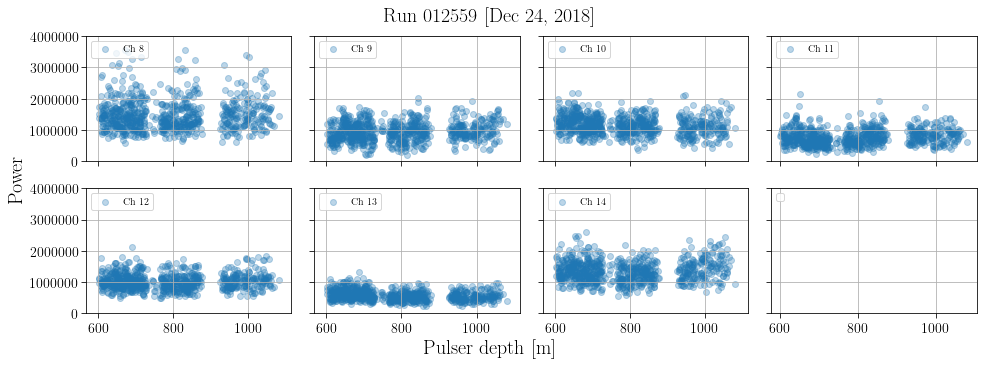

In [138]:
fig, ax = plt.subplots(2, 4, sharex='col', sharey='row', figsize=(14,5))
axs = ax.ravel()

# avgWf.drop(columns=['depth', 'recAng'])
# avgWf.columns[8:]
ch = 0
for a,b in zip(df.columns[8:15], df.columns[8:]):
    axs[ch].scatter(df.depth, df["%s"%a], alpha = 0.3, label = "Ch %i"%(ch+8))
    ch+=1
for ax in axs:
#     ax.set_xlabel("a")
#     ax.set_xlim(600,1000)
    ax.set_ylim(0,4E6)
    ax.set(xlabel="", ylabel = "")
#     ax.plot(df.depth, getOmega(df.rec_ang,0),"--",lw=3,c ="darkviolet", label = "$\Omega_{true}$")
    ax.grid()
#     ax.set_yscale('log')

    ax.legend(loc="upper left", fontsize=10)

fig.text(0.5, 0.03, 'Pulser depth [m]', ha='center', va='center', fontsize=20) 
fig.text(0.03, 0.5, 'Power', ha='center', va='center', rotation='vertical', fontsize=20)
plt.suptitle("Run 012559 [Dec 24, 2018]", fontsize=20)
plt.tight_layout(rect=[0.03, 0.03, 1, 0.95])
plt.savefig(my_path_plots+'/SpiceCorePolReco/PowervsDepth_run012559.png', dpi=250)


No handles with labels found to put in legend.


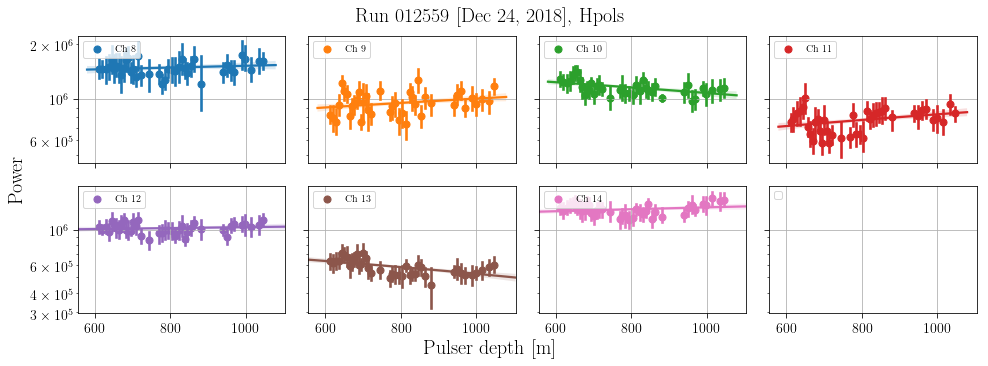

In [74]:
fig, ax = plt.subplots(2, 4, sharex='col', sharey='row', figsize=(14,5))
axs = ax.ravel()

# avgWf.drop(columns=['depth', 'recAng'])
# avgWf.columns[8:]
ch = 0
for a,b in zip(df.columns[8:15], df.columns[8:]):
#     axs[ch].scatter(df.depth, df["%s"%a], alpha = 0.3, label = "Ch %i"%(ch+8))
    sns.regplot(x=df.depth, y=df["%s"%a], x_bins=40, ax = axs[ch], label = "Ch %i"%(ch+8))
    ch+=1
for ax in axs:
#     ax.set_xlabel("a")
#     ax.set_xlim(600,1000)
#     ax.set_ylim(0,4E6)
    ax.set(xlabel="", ylabel = "")
#     ax.plot(df.depth, getOmega(df.rec_ang,0),"--",lw=3,c ="darkviolet", label = "$\Omega_{true}$")
    ax.grid()
    ax.set_yscale('log')

    ax.legend(loc="upper left", fontsize=10)

fig.text(0.5, 0.03, 'Pulser depth [m]', ha='center', va='center', fontsize=20) 
fig.text(0.03, 0.5, 'Power', ha='center', va='center', rotation='vertical', fontsize=20)
plt.suptitle("Run 012559 [Dec 24, 2018], Hpols", fontsize=20)
plt.tight_layout(rect=[0.03, 0.03, 1, 0.95])
plt.savefig(my_path_plots+'/SpiceCorePolReco/HpolPowervsDepthProfile_run012559.png', dpi=250)


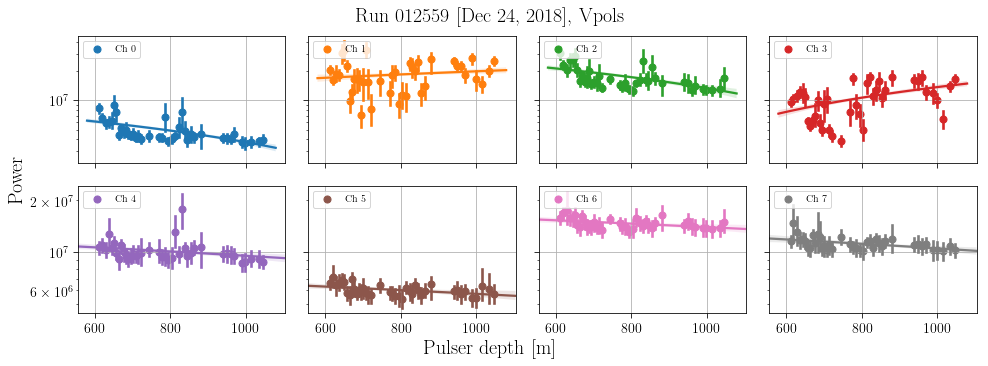

In [73]:
fig, ax = plt.subplots(2, 4, sharex='col', sharey='row', figsize=(14,5))
axs = ax.ravel()

# avgWf.drop(columns=['depth', 'recAng'])
# avgWf.columns[8:]
ch = 0
for a,b in zip(df.columns[:8], df.columns[8:]):
#     axs[ch].scatter(df.depth, df["%s"%a], alpha = 0.3, label = "Ch %i"%(ch+8))
    sns.regplot(x=df.depth, y=df["%s"%a], x_bins=40, ax = axs[ch], label = "Ch %i"%(ch))
    ch+=1
for ax in axs:
#     ax.set_xlabel("a")
#     ax.set_xlim(600,1000)
#     ax.set_ylim(0,4E6)
    ax.set(xlabel="", ylabel = "")
#     ax.plot(df.depth, getOmega(df.rec_ang,0),"--",lw=3,c ="darkviolet", label = "$\Omega_{true}$")
    ax.grid()
    ax.set_yscale('log')

    ax.legend(loc="upper left", fontsize=10)

fig.text(0.5, 0.03, 'Pulser depth [m]', ha='center', va='center', fontsize=20) 
fig.text(0.03, 0.5, 'Power', ha='center', va='center', rotation='vertical', fontsize=20)
plt.suptitle("Run 012559 [Dec 24, 2018], Vpols", fontsize=20)
plt.tight_layout(rect=[0.03, 0.03, 1, 0.95])
plt.savefig(my_path_plots+'/SpiceCorePolReco/VpolPowervsDepthProfile_run012559.png', dpi=250)


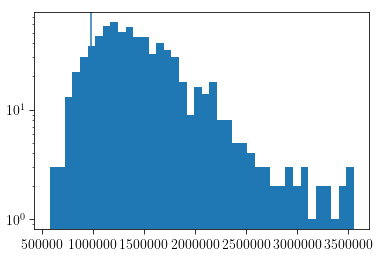

In [88]:
plt.hist(df.ch8Pow, bins = 40);
plt.axvline(noisePowerChan[8])
plt.yscale('log')

In [96]:
sub = df.ch8Pow-noisePowerChan[8]
len(sub[sub<0])/len(sub)

0.12717536813922356

In [128]:
ch = 0
chs = []
frac = []
for a,b in zip(df.columns[:16], df.columns[:16]):
    sub = df["%s"%a]-noisePowerChan[ch]
    frac.append(len(sub[sub<0])/len(sub))
    chs.append(ch)
    ch+=1

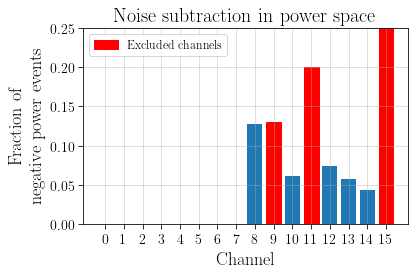

In [129]:
import matplotlib.patches as mpatches

plt.figure(figsize=(6,4))
barlist = plt.bar(chs,frac)
barlist[9].set_color('r')
barlist[11].set_color('r')
barlist[15].set_color('r')

plt.xticks(np.arange(0, 16, step=1));
plt.grid(alpha = 0.5)
plt.xlabel("Channel")
plt.ylabel("Fraction of \n negative power events")
plt.title("Noise subtraction in power space")
plt.ylim(0,0.25)


red_patch = mpatches.Patch(color='red', label='Excluded channels')
plt.legend(handles=[red_patch])
plt.tight_layout()


In [140]:
def getPsi(R):
#     theta = np.radians(theta)
#     phi = np.radians(phi)
#     numerator = np.cos(theta)*np.sin(phi)+R*np.cos(phi)
#     denominator = np.cos(theta)*np.cos(phi)-R*np.sin(phi)
    return np.degrees(np.arctan(R))

def getOmega(theta, R):
    theta = np.radians(theta)
    numerator = np.sin(theta)
    denominator = np.sqrt(1+R**2)
    return np.degrees(np.arccos(numerator/denominator))

def getR(powH, powH_noise, powV, powV_noise, chi):
    Rmeas = np.sqrt((powH-powH_noise)/(powV-powV_noise))
    return np.sqrt((1-chi)*Rmeas**2-chi)

In [142]:
def find68Perc(x,y):
    for bins in range(len(y)):
        integral = sum(y[:bins])*(x[1]-x[0])
        if(integral>0.68):
            break
    return x[bins]

No handles with labels found to put in legend.


2.844034863617114
[1.59053338]
2.879701756596688
[2.03926583]
2.6690174983794908
[2.66041432]
2.364544076487345
[0.00747964]
2.103524509711802
[1.22031703]
2.71172676773154
[1.38068892]
2.7334612237511693
[3.08856406]


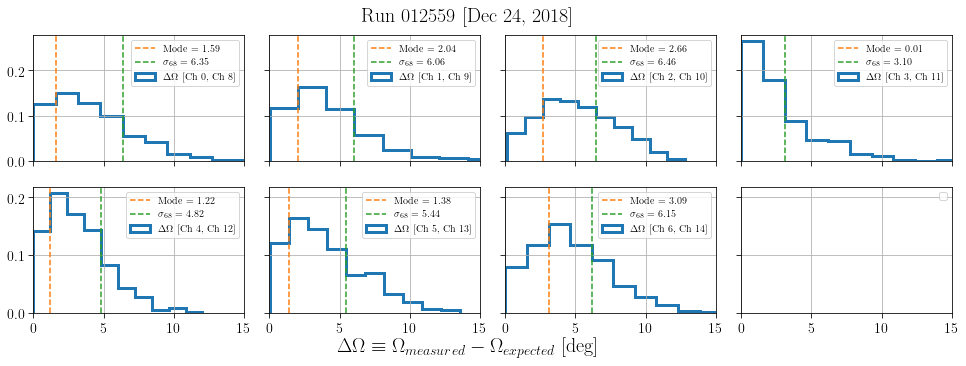

In [143]:
fig, ax = plt.subplots(2, 4, sharex='col', sharey='row', figsize=(14,5))
axs = ax.ravel()

# avgWf.drop(columns=['depth', 'recAng'])
# avgWf.columns[8:]
ch = 0
for a,b in zip(df.columns[:7], df.columns[8:]):
#     print(a,b)
    R = getR(df["%s"%b]/noisePowerChan[ch+8],1,df["%s"%a]/noisePowerChan[ch],1,0.)
    values = getOmega(df.rec_ang, R)
    pol = getOmega(df.rec_ang,0)
    delta = values[~np.isnan(values)]-pol[~np.isnan(values)]
    y, x, _ = axs[ch].hist(delta,label = "$\Delta\Omega$ [Ch %i, Ch %i]"%(ch,ch+8), bins = 10, histtype='step', stacked=True, fill=False, lw = 3, density = True);
    mode = x[np.where(y == y.max())]
    axs[ch].axvline(mode, ls="--", color = "C1", label = "Mode = %0.2f"%mode)
    Interval68Pct = find68Perc(x,y)
    axs[ch].axvline(Interval68Pct, ls="--", color = "C2", label = "$\sigma_{68}$ = %0.2f"%Interval68Pct)

    ch+=1
    print(delta.std())
    print(x[np.where(y == y.max())])
for ax in axs:
    ax.set_xlim(0,15)
#     ax.set_ylim(0,30)
    ax.set(xlabel="", ylabel = "")
    ax.grid()

    ax.legend(loc="upper right", fontsize=10)

fig.text(0.5, 0.03, '$\Delta\Omega \equiv \Omega_{measured}-\Omega_{expected}$ [deg]', ha='center', va='center', fontsize=20) 
# fig.text(0.03, 0.5, '$\Omega$ [deg]', ha='center', va='center', rotation='vertical', fontsize=20)
plt.suptitle("Run 012559 [Dec 24, 2018]", fontsize=20)
plt.tight_layout(rect=[0.03, 0.03, 1, 0.95])
# plt.savefig(my_path_plots+'/SpiceCorePolReco/deltaOmega_Amymethod_run012559.png', dpi=250)
